### Utility Functions

In [12]:
import tensorflow_datasets as tfds
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

ModuleNotFoundError: No module named 'tensorflow_datasets'

In [1]:
import zlib
import numpy as np
import pandas as pd
import sqlite3 as sql
from contextlib import contextmanager


_CMP = '_cmp'


@contextmanager
def open_db_connection(*, file, close=True,
                       lock=None, check_same_thread=False):
    """
    Safety wrapper for the database call.
    """

    if lock is not None:
        lock.acquire()

    con = sql.connect(database=file, check_same_thread=check_same_thread)

    try:
        yield con

    finally:
        if close:
            con.close()
        if lock is not None:
            lock.release()


def get_table_name(file):
    with open_db_connection(file=file, close=True) as con:
        res = pd.read_sql_query(sql="SELECT name FROM sqlite_master WHERE type ='table' AND name NOT LIKE 'sqlite_%'",
                                con=con)
        return res['name'].values


def rename_table(file, tables):
    old_names = get_table_name(file=file)

    with open_db_connection(file=file, close=True) as con:
        cur = con.cursor()
        for old in old_names:
            if old in tables:
                new = tables['old']
                cur.execute(f"ALTER TABLE {old} RENAME TO {new}")


def get_values_sql(*, file, table='db', columns=None, rows=-1,
                   values_only=False, squeeze_col=True, squeeze_row=True):
    """
    'i_samples' == i_samples_global
    """

    lock = None  # Lock is not necessary fo reading
    if columns is None:
        columns = '*'
    if isinstance(columns, str):
        columns = [columns]
    columns_str = ', '.join(map(str, columns))

    if isinstance(rows, int):
        rows = [rows]
    rows = np.array(rows)

    if rows[0] == -1:  # All samples
        with open_db_connection(file=file, close=True, lock=lock) as con:
            df = pd.read_sql_query(con=con, sql=f"SELECT {columns_str} FROM {table}")  # path_db

    else:
        rows_str = rows + 1  # Attention! Unlike in Python, SQL indices start at 1
        rows_str = ', '.join(map(str, rows_str))
        with open_db_connection(file=file, close=True, lock=lock) as con:
            df = pd.read_sql_query(sql=f"SELECT {columns_str} FROM {table} WHERE ROWID in ({rows_str})",
                                   index_col=rows, con=con)

    value_list = []
    if np.any(columns == ['*']):
        columns = df.columns.values

    if values_only:
        for col in columns:
            value = __decompress_values(value=df.loc[:, col].values, col=col)
            value_list.append(value)

        if len(df) == 1 and squeeze_row:
            for i in range(len(columns)):
                value_list[i] = value_list[i][0]

        if len(value_list) == 1 and squeeze_col:
            value_list = value_list[0]

        return value_list

    # Return pandas.DataFrame
    else:
        for col in columns:
            value = __decompress_values(value=df.loc[:, col].values, col=col)
            df.loc[:, col] = numeric2object_array(value)

        return df


def set_values_sql(*, file, table='db',
                   values, columns, rows=-1, lock=None):
    """
    Note: multidimensional numpy arrays have to be saved as flat to SQL otherwise the order is messed up
    values = ([...], [...], [...], ...)
    """

    # Handle rows argument
    if isinstance(rows, int):
        if rows == -1:
            rows = np.arange(len(values[0])).tolist()
        else:
            rows = [rows]

    rows_sql = (np.array(rows) + 1).tolist()  # Attention! Unlike in Python, SQL indices start at 1

    # Handle columns argument
    if isinstance(columns, str):
        columns = [columns]

    columns_str = '=?, '.join(map(str, columns))
    columns_str += '=?'

    values_rows_sql = change_tuple_order(values + (rows_sql,))
    values_rows_sql = list(values_rows_sql)
    query = f"UPDATE {table} SET {columns_str} WHERE ROWID=?"

    with open_db_connection(file=file, close=True, lock=lock) as con:
        cur = con.cursor()
        if len(values_rows_sql) == 1:
            cur.execute(query, values_rows_sql[0])
        else:
            cur.executemany(query, values_rows_sql)

        con.commit()


def df2sql(df, file, table='db', if_exists='fail', lock=None):
    """
    From DataFrame.to_sql():
        if_exists : {'fail', 'replace', 'append'}, default 'fail'
                   - fail: If table exists, do nothing.
                   - replace: If table exists, drop it, recreate it, and insert Measurements.
                   - append: If table exists, insert Measurements. Create if does not exist.
    """
    with open_db_connection(file=file, close=True, lock=lock) as con:
        df.to_sql(name=table, con=con, if_exists=if_exists, index=False)


# Helper
# Image Compression <-> Decompression
def __decompress_values(value, col):
    # SQL saves everything in binary form -> convert back to numeric, expect the columns which are marked as CMP
    if isinstance(value[0], bytes) and col[-4:] != _CMP:
        if col in ['i_world', 'i_sample',
                   'n_obstacles', 'rectangle_pos', 'rectangle_position', 'rectangle_size']:
            value = np.array([np.frombuffer(v, dtype=int) for v in value])
        else:
            value = np.array([np.frombuffer(v, dtype=float) for v in value])
    return value


def change_tuple_order(tpl):
    return tuple(map(lambda *tt: tuple(tt), *tpl))


def numeric2object_array(arr):
    n = arr.shape[0]
    arr_obj = np.zeros(n, dtype=object)
    for i in range(n):
        arr_obj[i] = arr[i]

    return arr_obj


def object2numeric_array(arr):
    s = np.shape(arr)
    arr = np.array([v for v in np.ravel(arr)])
    arr = np.reshape(arr, s + np.shape(arr)[1:])
    return arr


def initialize_array(shape, mode='zeros', dtype=None, order='c'):

    if mode == 'zeros':
        return np.zeros(shape, dtype=dtype, order=order)
    elif mode == 'ones':
        return np.ones(shape, dtype=dtype, order=order)
    elif mode == 'empty':
        return np.empty(shape, dtype=dtype, order=order)
    elif mode == 'random':
        return np.random.random(shape).astype(dtype=dtype, order=order)
    else:
        raise ValueError(f"Unknown initialization method {mode}")


def __dim_voxels(n_voxels, n_dim=None):
    if np.size(n_voxels) == 1:
        try:
            n_voxels = tuple(n_voxels)
        except TypeError:
            n_voxels = (n_voxels,)
        n_voxels *= n_dim
    else:
        n_voxels = tuple(n_voxels)

    return n_voxels


def image_array_shape(n_voxels, n_samples=None, n_dim=None, n_channels=None):
    """
    Helper to set the shape for an image array.
    n_samples=100,  n_voxels=64,          n_dim=2,    n_channels=None  ->  (100, 64, 64)
    n_samples=100,  n_voxels=64,          n_dim=3,    n_channels=2     ->  (100, 64, 64, 64, 2)
    n_samples=None, n_voxel=(10, 11, 12), n_dim=None, n_channels=None  ->  (10, 11, 12)
    """

    shape = __dim_voxels(n_voxels=n_voxels, n_dim=n_dim)

    if n_samples is not None:
        shape = (n_samples,) + shape
    if n_channels is not None:
        shape = shape + (n_channels,)

    return shape


def initialize_image_array(n_voxels, n_dim=None, n_samples=None, n_channels=None,
                           dtype=bool, initialization='zeros'):
    shape = image_array_shape(n_voxels=n_voxels, n_dim=n_dim, n_samples=n_samples, n_channels=n_channels)
    return initialize_array(shape=shape, mode=initialization, dtype=dtype)


# Image Compression <-> Decompression
def img2compressed(img, n_dim=-1, level=9):
    """
    Compress the given image with the zlib routine to a binary string.
    Level of compression can be adjusted. A timing with respect to different compression levels for decompression showed
    no difference, so the highest level is default, this corresponds to the largest compression.
    For compression it is slightly slower but this happens just once and not during keras training, so the smaller
    needed memory was favoured.
    Alternative:
    <-> use numpy sparse for the world images, especially in 3d  -> zlib is more effective and more general
    """

    if n_dim == -1:
        return zlib.compress(img.tobytes(), level=level)
    else:
        shape = img.shape[:-n_dim]
        img_cmp = np.empty(shape, dtype=object)
        for idx in np.ndindex(*shape):
            img_cmp[idx] = zlib.compress(img[idx, ...].tobytes(), level=level)
        return img_cmp


def compressed2img(img_cmp, n_voxels, n_dim=None, n_channels=None, dtype=bool):
    """
    Decompress the binary string back to an image of given shape
    """

    shape = np.shape(img_cmp)

    if shape:
        n_samples = np.size(img_cmp)
        img_arr = initialize_image_array(n_voxels=n_voxels, n_dim=n_dim, n_samples=n_samples, n_channels=n_channels,
                                         dtype=dtype)
        for i in range(n_samples):
            img_arr[i, ...] = np.fromstring(zlib.decompress(img_cmp[i]), dtype=dtype).reshape(
                image_array_shape(n_voxels=n_voxels, n_dim=n_dim, n_channels=n_channels))
        return img_arr

    else:
        return np.fromstring(zlib.decompress(img_cmp), dtype=dtype).reshape(
            image_array_shape(n_voxels=n_voxels, n_dim=n_dim, n_channels=n_channels))

### Main

/tmp/ipykernel_11/1560005776.py:162: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  value = np.array([np.frombuffer(v, dtype=int) for v in value])
/tmp/ipykernel_11/1560005776.py:273: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  img_arr[i, ...] = np.fromstring(zlib.decompress(img_cmp[i]), dtype=dtype).reshape(
/tmp/ipykernel_11/3746585752.py:33: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  i_world = np.asscalar(paths.i_world[i])


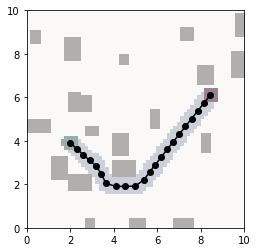

,n_obstacles,rectangle_position,rectangle_size,edt_img_cmp,obst_img_cmp,obst_img_latent
0,21,"[43, 0, 51, 22, 16, 34, 30, 0, 61, 56, 60, 47,...","[6, 3, 3, 6, 3, 5, 5, 3, 3, 7, 4, 5, 5, 7, 3, ...",b'x\xda\xed]Mh\x1dU\x14\xd6]\xa0H\x8cQ\x13\xad...,"b""x\xda\xed\x95K\x0e\xc0 \x08D\xf1\xfe\x97n\x9...","[0.0, 0.0, 1.8461995124816895, 0.0, 0.0, 3.215..."
1,17,"[47, 31, 27, 33, 16, 48, 47, 31, 21, 6, 10, 25...","[3, 5, 3, 3, 4, 5, 7, 7, 6, 7, 7, 6, 7, 6, 4, ...",b'x\xda\xed]_hVe\x18ow\x03\x8b\xb5\x96\xce\x9a...,"b""x\xda\xed\x95A\n\x00 \x08\x04\xf5\xff\x9f\x0...","[0.0, 0.0, 1.9913780689239502, 0.0, 0.0, 2.859..."
2,17,"[33, 55, 15, 31, 6, 12, 47, 4, 10, 5, 51, 25, ...","[6, 3, 7, 5, 5, 3, 3, 6, 4, 3, 5, 3, 4, 4, 3, ...",b'x\xda\xed]ml\x14E\x18\x96\x98h\x134\x80\x05Z...,b'x\xda\xed\xd6\xc1\n\x00 \x08\x03P\xfd\xff\x9...,"[0.0, 0.0, 4.600570201873779, 0.0, 0.0, 4.4898..."
3,22,"[61, 30, 14, 19, 30, 40, 4, 37, 20, 13, 17, 61...","[3, 3, 7, 7, 6, 3, 6, 5, 4, 3, 7, 3, 3, 7, 5, ...",b'x\xda\xed]Mh]E\x14\xb6\xbb@\x91\x10\x83&*T\x...,b'x\xda\xed\xd6A\x0e\x800\x08\x04\xc0\xf2\xffO...,"[0.0, 0.0, 2.994356393814087, 0.0, 0.0, 5.8590..."
4,17,"[6, 54, 33, 6, 20, 13, 57, 8, 12, 30, 10, 3, 3...","[4, 7, 5, 5, 3, 3, 5, 4, 6, 6, 5, 5, 3, 3, 6, ...",b'x\xda\xed]kl\x14U\x14\x96?\xa6\t\x1a\xa8\x05...,b'x\xda\xed\xd7\xcd\x0e\x00\x11\x0c\x04`\xf3\x...,"[0.0, 0.0, 6.124979019165039, 0.0, 0.0, 4.2713..."
...,...,...,...,...,...,...
4995,15,"[33, 23, 25, 28, 52, 37, 7, 15, 19, 30, 32, 31...","[7, 5, 6, 3, 5, 4, 3, 3, 7, 3, 3, 6, 5, 7, 6, ...",b'x\xda\xed][l\x14U\x18\x967\x12b\xa0V(X\x02\x...,"b""x\xda\xed\xd6A\x0e\x80 \x0c\x04@\xf6\xff\x9f...","[0.0, 0.0, 2.238067150115967, 0.0, 0.0, 3.1371..."
4996,14,"[45, 20, 59, 38, 0, 46, 12, 40, 20, 9, 27, 41,...","[7, 6, 4, 3, 6, 5, 6, 7, 7, 6, 6, 6, 3, 3, 3, ...",b'x\xda\xed]]l\x15E\x14\xb6oM\xd0\x14Dh)Dl\xa1...,b'x\xda\xed\x94I\x0e\x00!\x08\x04\xe1\xff\x9f6...,"[0.0, 0.0, 2.534562110900879, 0.0, 0.0, 5.5209..."
4997,10,"[7, 40, 31, 61, 21, 39, 30, 32, 56, 31, 54, 3,...","[3, 3, 5, 3, 6, 3, 5, 4, 3, 5, 5, 4, 4, 7, 6, ...",b'x\xda\xed]\x7fLUU\x1c\xcf\x7f\x8a\xcd\x1a\x1...,b'x\xda\xed\xd41\n\x000\x08\x04\xc1\xdc\xff?\x...,"[0.0, 0.0, 0.012410104274749756, 0.0, 0.0, 6.0..."
4998,10,"[24, 31, 43, 9, 21, 5, 42, 7, 45, 23, 36, 26, ...","[3, 4, 3, 3, 7, 6, 6, 5, 4, 7, 6, 5, 4, 3, 3, ...",b'x\xda\xed]]l\x14U\x14\x96\xb7&\xc4\x94Z\xa1b...,b'x\xda\xed\xd3A\n\x00 \x08\x05Q\xbd\xff\xa5\x...,"[0.0, 0.0, 2.094358205795288, 0.0, 0.0, 5.3867..."


In [2]:
import numpy as np

file = 'SingleSphere02.db'


n_voxels = 64
voxel_size = 10 / 64     # in m
extent = [0, 10, 0, 10]  # in m
n_waypoints = 22  # start + 20 inner points + end
n_dim = 2
n_paths_per_world = 1000
n_worlds = 5000


worlds = get_values_sql(file=file, table='worlds')
obstacle_images = compressed2img(img_cmp=worlds.obst_img_cmp.values, n_voxels=n_voxels, n_dim=n_dim)

# always 1000 paths belong to one world
# 0...999     -> world 0
# 1000...1999 -> world 1
# 2000...2999 -> world 2
paths = get_values_sql(file=file, table='paths', rows=[0, 1, 2, 3, 4])
#paths = get_values_sql(file=file, table='paths', rows=[0, 1, 2, 2000, 3000])
path_images = compressed2img(img_cmp=paths.path_img_cmp.values, n_voxels=n_voxels, n_dim=n_dim)
start_images = compressed2img(img_cmp=paths.start_img_cmp.values, n_voxels=n_voxels, n_dim=n_dim)
end_images = compressed2img(img_cmp=paths.end_img_cmp.values, n_voxels=n_voxels, n_dim=n_dim)

q_paths = object2numeric_array(paths.q_path.values)
q_paths = q_paths.reshape(-1, n_waypoints, n_dim)

# Plot and example
i = 0
i_world = np.asscalar(paths.i_world[i])

import matplotlib.pyplot as plt
fig, ax = plt.subplots()

ax.imshow(obstacle_images[i_world].T, origin='lower', extent=extent, cmap='binary',)
ax.imshow(start_images[i].T, origin='lower', extent=extent, cmap='Greens', alpha=0.4)
ax.imshow(end_images[i].T, origin='lower', extent=extent, cmap='Reds', alpha=0.4)
ax.imshow(path_images[i].T, origin='lower', extent=extent, cmap='Blues', alpha=0.2)

ax.plot(*q_paths[i].T, color='k', marker='o')
plt.show()

worlds

In [3]:
import numpy as np

file = 'SingleSphere02.db'
world_1_paths = [x for x in range(1000)]
paths = get_values_sql(file=file, table='paths', rows=world_1_paths)
paths

,i_world,i_sample,q_start,q_end,q_path,start_img_cmp,end_img_cmp,path_img_cmp
0,[0],[0],"[1.985634777216815, 3.9134606855813745]","[8.430235242261743, 6.0912571762168035]","[1.985634777216815, 3.9134606855813745, 2.2853...","b""x\xda\xed\xcc\xb1\r\x00\x00\x08\xc30\xfa\xff...",b'x\xda\xed\xcb1\x01\x00\x00\x08\x03\xa0\xd9\x...,"b'x\xda\xed\x96A\n\x000\x08\xc3\xcc\xff?\xbd?,..."
1,[0],[1],"[6.639911702397317, 5.690468072859392]","[9.355108112029528, 2.756885061785996]","[6.639911702397317, 5.690468072859392, 6.82627...",b'x\xda\xed\xcf\xa1\x11\x000\x0c\x03\xb1x\xff\...,"b""x\xda\xed\xcc\xb1\r\x00 \x00\xc3\xb0\xf6\xff...",b'x\xda\xed\xd4!\x0e\x00 \x10\xc4@\xfa\xffO\xe...
2,[0],[2],"[3.501051914617497, 5.122907197533134]","[6.665909191341896, 1.418474585678716]","[3.501051914617497, 5.122907197533134, 3.72904...",b'x\xda\xed\xcb\xb1\r\x000\x08\x03\xb0\xf0\xff...,b'x\xda\xed\xcb\xb1\r\x00\x00\x08\x03\xa0\xf6\...,b'x\xda\xed\xd5\xc1\t\xc00\x0c\xc0\xc0h\xff\xa...
3,[0],[3],"[2.3086377813879153, 0.65138631522723]","[8.754335178250809, 8.640019152767758]","[2.3086377813879153, 0.65138631522723, 2.76055...",b'x\xda\xed\xd2\xb1\x01\x00\x00\x08\xc20\xf9\x...,b'x\xda\xed\xd1\xa1\x01\x00\x00\x08\xc30\xf6\x...,b'x\xda\xed\xd7A\n\x001\x08\x04A\xfb\xff\x9f\x...
4,[0],[4],"[8.09511173571716, 5.66874743829461]","[8.700998926664088, 5.227932762040475]","[8.09511173571716, 5.66874743829461, 8.1239635...",b'x\xda\xed\xd2\xa1\x01\x00\x00\x08\x02A\xd9\x...,b'x\xda\xed\xcf\xc1\r\x000\x0c\x02\xb1\xb0\xff...,b'x\xda\xed\xd3\xc1\t\x00@\x08\x03A\xd3\x7f\xd...
...,...,...,...,...,...,...,...,...
995,[0],[995],"[3.7629150643574265, 0.7228898091393602]","[6.717557545393671, 9.45710349667185]","[3.7629150643574265, 0.7228898091393602, 4.101...",b'x\xda\xed\xd2\xc1\t\x00\x00\x08\x031\xdd\x7f...,b'x\xda\xed\xcb1\x11\x00\x00\x08\x04\xa0\xb7\x...,"b""x\xda\xed\xd5\xc1\t\x00 \x0c\xc5\xd0\xfe\xfd..."
996,[0],[996],"[9.109080721245768, 6.190917666098743]","[0.6036705472825762, 7.922786294901037]","[9.109080721245768, 6.190917666098743, 8.68833...",b'x\xda\xed\xcb\xb1\r\x000\x08\x03\xb0\xf0\xff...,b'x\xda\xed\xcc\xb1\r\x00 \x00\xc3\xb0\xf6\xff...,b'x\xda\xed\xd4Q\x0e\x00@\x04C\xc1\xf6\xfe\x97...
997,[0],[997],"[7.348764421692412, 1.1695919410267173]","[6.908778456294491, 4.12179367957318]","[7.348764421692412, 1.1695919410267173, 7.3278...",b'x\xda\xed\xcb\xb1\r\x00\x00\x08\x03\xa0\xfa\...,b'x\xda\xed\xcb\xb1\r\x000\x08\x03\xb0\xf0\xff...,b'x\xda\xed\xd2!\x12\x00 \x08EA\xfe\xfd/m\xb0Z...
998,[0],[998],"[8.01199855174059, 2.9057302034030728]","[3.5282303838640448, 1.809958637452904]","[8.01199855174059, 2.9057302034030728, 7.80226...","b""x\xda\xed\xcb\xc1\t\x000\x08\x04\xb0s\xff\xa...",b'x\xda\xed\xcf\xc1\r\x000\x0c\x02\xb1\xb0\xff...,b'x\xda\xed\xd6\xc1\t\x00@\x08\xc4\xc0\xdd\xfe...


In [20]:
import tensorflow_datasets as tfds
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)
dataset

ModuleNotFoundError: No module named 'tensorflow_datasets'

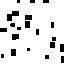

In [11]:
def load_data
from PIL import Image
import PIL.ImageOps  

background_plus_end_points = obstacle_images[i_world].T + start_images[i].T + end_images[i].T 

Image.fromarray(np.invert(background_plus_end_points))

In [4]:
def load_image()

#X_test = paths.q_path

In [5]:
ax.plot(*q_paths[i].T, color='k', marker='o')
plt.show()

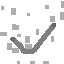

In [3]:
from PIL import Image
import PIL.ImageOps  

#read image
background = PIL.ImageOps.flip(Image.fromarray(np.invert(obstacle_images[i_world].T)).convert("RGBA"))
start_point = PIL.ImageOps.flip(Image.fromarray(np.invert(start_images[i].T)).convert("RGBA"))
end_point = PIL.ImageOps.flip(Image.fromarray(np.invert(end_images[i].T)).convert("RGBA"))
path_image = PIL.ImageOps.flip(Image.fromarray(np.invert(path_images[i].T)).convert("RGBA"))

base_image = Image.blend(background, start_point, 0.2)
base_image = Image.blend(base_image, end_point, 0.2)
base_plus_path = Image.blend(base_image, path_image, 0.5)
base_plus_path

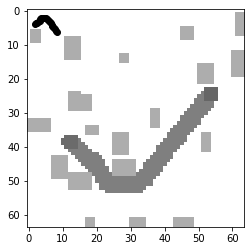

In [18]:
plt.imshow(base_plus_path)

plt.plot(*q_paths[i].T, color='k', marker='o')

plt.show()

In [8]:
from keras.models import Sequential
from keras.layers import Dense

y_train = paths.q_path[:900]
X_train = paths.drop("q_path", axis=1)[:900]
# create ANN model
model = Sequential()
 
# Defining the Input layer and FIRST hidden layer, both are same!
model.add(Dense(units=5, input_dim=7, kernel_initializer='normal', activation='relu'))
 
# Defining the Second layer of the model
# after the first layer we don't have to specify input_dim as keras configure it automatically
model.add(Dense(units=5, kernel_initializer='normal', activation='tanh'))
 
# The output neuron is a single fully connected node 
# Since we will be predicting a single number
model.add(Dense(2, kernel_initializer='normal'))
 
# Compiling the model
model.compile(loss='mean_squared_error', optimizer='adam')
 
# Fitting the ANN to the Training set
model.fit(X_train, y_train ,batch_size = 20, epochs = 50, verbose=1)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3444, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_57/1746000438.py", line 1, in <module>
    from keras.models import Sequential
ModuleNotFoundError: No module named 'keras'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2064, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'ModuleNotFoundError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/IPython/core/ultratb.py", line 1101, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/opt/conda/lib/python3.9/site-packa

TypeError: object of type 'NoneType' has no len()